## About this post 

This tutorial is the third part of a series about natural language processing (NLP). Our goal is to train a neural network to do sentiment analysis, or in other words to understand whether some text is globally positive or negative. The first layer of our neural network will perform an operation called word embedding, which is essential in NLP with deep learning. 

In this post, you will learn: 

* what is word embedding 
* how to do word embedding with keras
* how to do a simple sentiment analysis
* how to visualize the results of word embedding 

**Prerequisites:**

* You should be familiar with keras. If that's not the case, you can follow my tutorial on [deep learning for image recognition with keras](https://thedatafrog.com/deep-learning-keras/)

You can run the code of this tutorial on the google colab platform by clicking [here](https://colab.research.google.com/github/cbernet/maldives/blob/master/imdb/imdb_embed.ipynb).

If you have installed [anaconda for python 3.X](https://www.anaconda.com/distribution/), you can also run [this jupyter notebook](https://github.com/cbernet/maldives/blob/master/imdb/imdb_embed.ipynb) on your machine. For that, you need the following packages: jupyter matplotlib keras tensorflow numpy. 

And of course you can simply read through if you prefer. 


## The IMDB dataset

We will work with the IMDB dataset, which contains 25,000 movie reviews from [IMDB](https://www.imdb.com/). Each review is labeled as positive or negative from the rating provided by users together with their reviews. 

The dataset is distributed with keras. Before loading it in memory, we initialize our tools: 

In [1]:
# get reproducible results
from numpy.random import seed
seed(0xdeadbeef)
from tensorflow import set_random_seed
set_random_seed(0xdeadbeef)

# needed to run on a mac: 
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import keras
imdb = keras.datasets.imdb
num_words = 20000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(seed=1, num_words=num_words)

Using TensorFlow backend.


The first review looks like this:

In [3]:
print(train_data[0])
print('label:', train_labels[0])

[1, 13, 28, 1039, 7, 14, 23, 1856, 13, 104, 36, 4, 699, 8060, 144, 297, 14, 175, 291, 18, 4, 375, 1784, 153, 38, 15, 75, 92, 859, 51, 16, 5, 15, 75, 377, 24, 8, 81, 4, 172, 2497, 174, 40, 1489, 49, 84, 11, 4, 2030, 3039, 121, 36, 92, 4881, 14, 20, 2, 9, 40, 6, 2, 621, 18, 148, 37, 191, 1941, 42, 511, 14, 20, 9, 17, 76, 253, 17, 269, 8, 3336, 4, 2, 8, 1278, 6, 543, 2647, 10, 10, 308, 3102, 2, 47, 43, 188, 46, 7, 1172, 5, 240, 2854, 145, 8, 4, 154, 3243, 11, 4819, 58, 18, 35, 32, 8, 327, 823, 7, 7350, 7, 265, 308, 1828, 145, 1646, 4, 154, 890, 5, 9, 14412, 34, 362, 2515, 154, 1914, 5, 27, 15227, 2, 17, 36, 837, 5, 1941, 32, 367, 4, 96, 10, 10, 13, 62, 386, 14, 48, 13, 16, 3178, 42, 48, 11, 882, 294, 16, 3412, 2, 4360, 2, 34, 6, 1042, 18, 2, 345, 96, 14, 9, 6, 862, 526, 3757, 917, 5, 60, 1055, 13, 115, 197, 474, 1829, 15, 2006, 7, 6791, 113, 19, 4, 2, 261, 13, 104, 4, 1653, 173, 7, 4, 65, 143, 4, 3801, 1366, 548, 844, 5, 4, 837, 1396, 27, 369, 459, 44, 68, 4731, 5, 181, 8, 607, 4, 6791, 3

We see that the text of the review has been encoded as a sequence of integers. Please refer to [part 2](https://thedatafrog.com/text-preprocessing-machine-learning-yelp/) of this tutorial series if you want to understand how such an encoding can be done in practice. 

Each word in the text is represented as an integer. A dictionary called the **vocabulary** links each word to a unique integer. In the example above, we see that the integer 4 is repeated many times. This integer corresponds to a very frequent word. And actually, the more frequent a word, the lower the integer.    

To decode the review, we need to make use of the vocabulary:

In [4]:
# A dictionary mapping words to an integer index
vocabulary = imdb.get_word_index()

# The first indices are reserved
vocabulary = {k:(v+3) for k,v in vocabulary.items()} 
vocabulary["<PAD>"] = 0
# See how integer 1 appears first in the review above. 
vocabulary["<START>"] = 1
vocabulary["<UNK>"] = 2  # unknown
vocabulary["<UNUSED>"] = 3

# reversing the vocabulary. 
# in the index, the key is an integer, and 
index = dict([(value, key) for (key, value) in vocabulary.items()])

def decode_review(text):
    '''converts encoded text to human readable form.
    each integer in the text is looked up in the index, and 
    replaced by the corresponding word.
    '''
    return ' '.join([index.get(i, '?') for i in text])


In [5]:
decode_review(train_data[0])

"<START> i have copy of this on vhs i think they the television networks should play this every year for the next twenty years so that we don't forget what was and that we remember not to do the same mistakes again like putting some people in the director's chair where they don't belong this movie <UNK> is like a <UNK> musical for those who can't sing or act this movie is as much fun as trying to teach the <UNK> to drive a city bus br br john hood <UNK> has just got out of prison and he's headed back to the old neighborhood in serving time for an all to nice crime of necessity of course john heads back onto the old street and is greeted by kids dogs old ladies and his peer <UNK> as they dance and sing all along the way br br i would recommend this if i was sentimental or if in truth someone was smoking <UNK> pot <UNK> by a doctor for <UNK> either way this is a poorly directed scripted acted and even produced i never thought i'd sat that satire of ghetto life with the <UNK> although i t

We see that integer 4 indeed corresponds to a very frequent word, "the". Now what do we do with this dataset? We can see two issues if we are to use it as input to a neural network:

* The reviews have a variable number of words, while the network has a fixed number of neurons.
* The words are completely independent. For example, "brilliant" and "awesome" correspond to two different integers, and the neural network does not know a priori that these two adjectives have similar meaning. 

Let's deal with the first issue. To get a fixed length input, we can simply truncate the reviews to a fixed number of words, say 256. For reviews that have more than 256 words, we will keep only the first 256 words. For shorter reviews, we will fill the unused word slots with zeros. With keras, this is easy to do:

In [6]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=vocabulary["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=vocabulary["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [7]:
train_data[1]

array([    1,   103,   450,   576,    73,  2896,     8,     4,   213,
           7,   897,    13,    16,   576,  3521,    19,     4,    22,
           4,    22,    16,   465,   728,     4,  2563,     4,  1460,
           4,  3237,     5,     6,    55,   576,  1078,  2734,    10,
          10,    13,    69,  2721,   873,     8,    67,   111,   318,
         302,     5,    40,     6, 13892,     2,    12,  4280,    72,
         245,    19,     4,  4211,     5,     4,     2,     7,    12,
        1620,    13,   244,   174,  2654,   245,    19,   129,  7102,
          19,     4,   979,     7,     4,    65,     5,   129,   459,
           7,     4,   318,   302,    25,    80,   140,     6,   196,
          96,    61,   464,    13,    80,   407,    30,     4,  2217,
           7,   129,   337,  1333,    10,    10,  2127,     2,     4,
         118,   284,  1344,    16,     4,   612,    31,  1099,    25,
          93,  1792,  7606,   168,    40,     6,   506,  1079,     8,
           2,    10,

The first issue is solved: Our reviews are now of fixed length. The second issue is addressed below. 

## Embedding: Why is it Needed? 

In this section, we will see why a standard dense neural network is by essence unable to deal with this dataset.

As we have seen in my post about [the 1-neuron network](https://thedatafrog.com/logistic-regression/), neural networks are simply a function of their inputs. In the 1-neuron network (or logistic regression), this function is 

$$ f( \{ x_i \} ) = \sigma (z)$$

where $\sigma$ is the sigmoid function and where the weighted input $z$ of the only neuron is computed as 

$$z= b+ \sum_{i} w_i x_i$$ 

In this expression, the sum runs over all input variables $x_i$, and $b$ is the bias of the neuron. When the network is trained, the network parameters (the biases and weights) are tuned for best performance. 

Now what would happen if we tried to classify our reviews as either positive or negative with a logistic regression?

The input variables would be the 256 integers in the review array. Let us assume a positive weight $w_i$ for variable i. Since the sigmoid function increases monotonically, when variable $i$ increases, the output of the network, which is the probability for the review to be positive, increases.

But there is no reason for variable $i$ to be correlated in any way to the probability for the review to be positive! 

For example, variable $i$ could be 27 (corresponding to the word "bad"), 118 ("good"), or 1562 ("awful"). The review does not look more positive when the integer gets bigger. 
In other words, the actual value of the integer code for a given word does not carry any information by itself on the quality of the review. This value is arbitrary, and would be different with another encoding algorithm. 

Clearly, a logistic regression would not be of any use in classifying our reviews.

Maybe the logistic regression is too simple, and a more complex dense network would help? 

Actually, that's not the case. Indeed, in a dense network with hidden layers, each of the neurons in the first hidden layer behaves as the single neuron of the logistic regression. So more complex dense networks suffer from the same problems as the simple logistic regression. 


## Simple sentiment analysis with embedding

Embedding is a way to extract the meaning of a word. In the embedding process, each word (or more precisely, each integer corresponding to a word) is translated to a vector in N-dimensional space. 

That does sound complicated! but it's not.  

To understand better, we're going to perform the embedding in two dimensions only. Each word is then going to be converted to a vector with two coordinates $(x,y)$, and these coordinates can be represented as a point in a plane. 

As you will see below, the text of a review will appear as an ensemble of points, and the points with similar meaning will be grouped together. Looking at the distribution of the points in 2D, the neural network will be able to predict whether the review is positive or negative. 

In practice, here is how to do that in keras. If anything is unclear in the steps below, you might want to look at my post about [deep learning for image recognition with keras](https://thedatafrog.com/deep-learning-keras/).

In [8]:

model = keras.Sequential()

# the first layer is the embedding layer. 
# we indicate the number of possible words, 
# the dimension of the embedding space, 
# and the maximum size of the text. 
model.add(keras.layers.Embedding(len(vocabulary), 2, input_length=256))

# the output of the embedding is multidimensional, 
# with shape (256, 2)
# for each word, we obtain two values, 
# the x and y coordinates
# we flatten this output to be able to 
# use it in a dense layer
model.add(keras.layers.Flatten())

# dropout regularization
model.add(keras.layers.Dropout(rate=0.5))

# small dense layer. It's role is to analyze 
# the distribution of points from embedding
model.add(keras.layers.Dense(5))

# final neuron, with sigmoid activation 
# for binary classification
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 2)            177176    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 179,747
Trainable params: 179,747
Non-trainable params: 0
_________________________________________________________________


As you can see, it is enough to add an embedding layer to our neural network to perform embedding. And it could be a bit surprising to see that we only have to provide three arguments to construct the embedding layer: the length of the vocabulary, the number of dimensions in the embedding space, and the number of words in the input text. 

In the summary printout just above, we see that the embedding layer represents 177176 parameters. At first, these parameters are random, and the embedding is just meaningless. During the training, these parameters are tuned and the network becomes more and more capable to extract the meaning of the words.

Now that the model is ready, we compile it and we train it. There is no need for a GPU here, as the training will be quite fast even on a CPU.

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [10]:
history = model.fit(train_data,
                    train_labels,
                    epochs=5,
                    batch_size=100,
                    validation_data=(test_data, test_labels),
                    verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 4s 171us/step - loss: 0.6798 - acc: 0.5610 - val_loss: 0.5992 - val_acc: 0.7508
Epoch 2/5
25000/25000 [==============================] - 4s 144us/step - loss: 0.4212 - acc: 0.8211 - val_loss: 0.3343 - val_acc: 0.8661
Epoch 3/5
25000/25000 [==============================] - 4s 143us/step - loss: 0.2902 - acc: 0.8825 - val_loss: 0.2936 - val_acc: 0.8806
Epoch 4/5
25000/25000 [==============================] - 4s 147us/step - loss: 0.2387 - acc: 0.9040 - val_loss: 0.2855 - val_acc: 0.8821
Epoch 5/5
25000/25000 [==============================] - 4s 148us/step - loss: 0.2124 - acc: 0.9154 - val_loss: 0.2898 - val_acc: 0.8799


We can now look at the evolution of the training and testing accuracies as a function of time, with this small function: 

In [11]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
  acc = history.history['acc']
  test_acc = history.history['val_acc']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.figure()

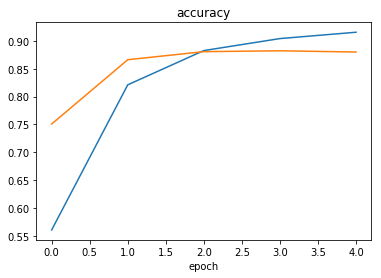

<Figure size 432x288 with 0 Axes>

In [12]:
plot_accuracy(history)

We are able to reach a classification accuracy over 85%. The training accuracy continuously increases while the training accuracy plateaus after the second epoch. This means that we [overfit](https://thedatafrog.com/overfitting-illustrated/). But in this post, that's none of our concern: we only want to understand  what is embedding. 

## Visualizing embedding

To investigate embedding, we create a function that provides the output of the embedding layer for a given input:

In [13]:

# with a Sequential model
get_embed_out = keras.backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

Then, we use this function to get the distribution of points from the embedding of the first review in the validation sample: 

In [14]:
layer_output = get_embed_out([test_data[0]])
print(type(layer_output), len(layer_output), layer_output[0].shape)

<class 'list'> 1 (256, 2)


We see that layer_output is a list with a single element containing the array of embedded words. So let's get this array and plot it: 

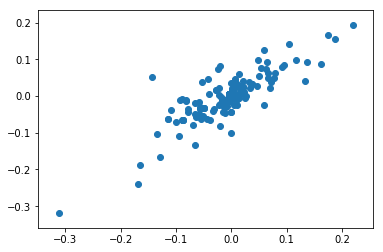

In [15]:
words = layer_output[0]
plt.scatter(words[:,0], words[:,1])

We see that the distribution of embedded words for this review has an elongated shape. But what does it mean? 

Let's create our own review, encode it, and embed it to see what happens: 

In [16]:
review = ['great', 'brilliant','crap','bad', 
          'fantastic', 'movie', 'seagal']
enc_review = [vocabulary[word] for word in review]
enc_review

[87, 530, 595, 78, 777, 20, 3272]

In [17]:
words = get_embed_out([enc_review])[0]

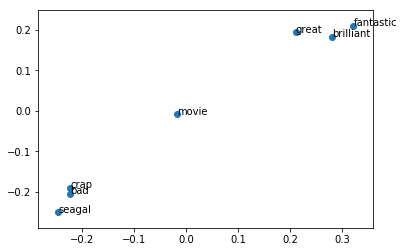

In [18]:
plt.scatter(words[:,0], words[:,1])
for i, txt in enumerate(review):
    plt.annotate(txt, (words[i,0], words[i,1]))

We see that words with a similar meaning are indeed grouped together. There is one group with "great", "brilliant", "fantastic". This area of the plane contains the words that carry a positive meaning. On the other side, we have "bad", "crap", and ... "seagal". It seems that hiring Steven Seagal for your movie guarantees bad reviews on IMDB! 

The word "movie", finally, does not carry much meaning about the quality of the review, and ends up in the middle.

**Exercise**: I found a bad actor, that's easy, especially with Steven around. Can you find a good one?  

Now let's plot the distribution of points for a few reviews with the following function: 

In [19]:
import math
def plot_review(i):
    # plot the distribution of points
    enc_words = test_data[i]
    emb_words = get_embed_out([enc_words])[0]
    plt.figure(figsize=(8,8))
    plt.scatter(emb_words[:,0], emb_words[:,1])
    # use the label as title: 1 is positive, 
    # 0 is negative
    plt.title(test_labels[i])
    # for words that are far enough from (0,0), 
    # print the word
    for i, (enc_word, emb_word) in enumerate(zip(enc_words, emb_words)):
        word = index[enc_word]
        x, y = emb_word
        if math.sqrt(x**2 + y**2)>0.2: 
            plt.annotate(word, (x, y))
    # fix the range in x and y to be able to compare
    # the distributions of different reviews
    axes = plt.gca()
    axes.set_xlim([-0.5,0.5])
    axes.set_ylim([-0.5, 0.5])
    axes.set_aspect('equal', adjustable='box')

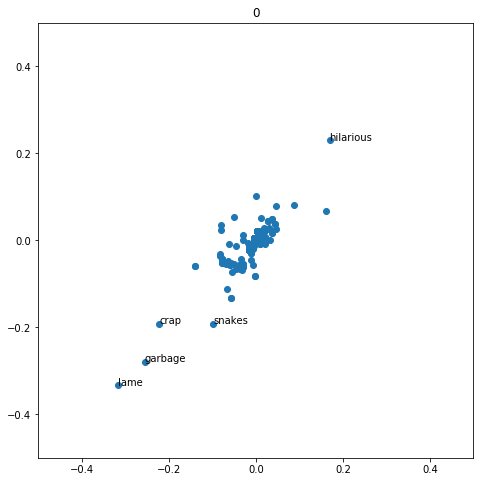

In [20]:
plot_review(15)

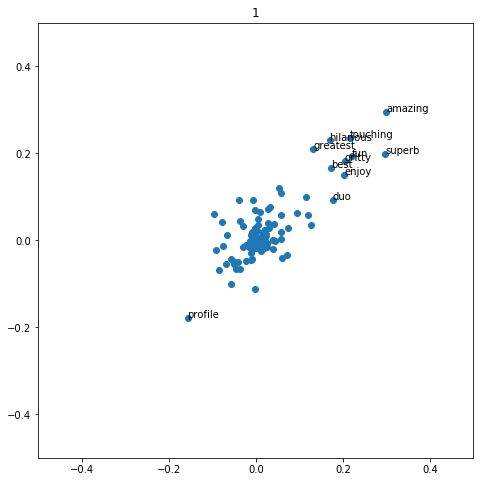

In [21]:
plot_review(17)

You can plot a few more reviews if you wish, by changing the review index in the commands above. 

We see that positive reviews tend to have words with a meaning similar to "great", "brilliant", and "fantastic", while negative reviews tend to have words with a meaning similar to "seagal".

The goal of the dense layer in our network is to summarize the information in the whole distribution of points for each review. 

Now let's [go back](https://thedatafrog.com/word-embedding-sentiment-analysis/#wrapup) and wrap up with an interesting discussion about Steven Seagal and embedding.